# Parte común

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

# Creación de dataset

In [3]:
annotations = pd.read_csv('/content/drive/My Drive/GANsNRoses/datasets/output/annotations_v2.csv', sep=';').drop(columns=['agreeableness', 'disagreeableness', 'shyness', 'neutral']).set_index('picture')
annotations.head()

,anger,anticipation,arrogance,disgust,fear,gratitude,happiness,humility,love,optimism,pessimism,regret,sadness,shame,surprise,trust
picture,,,,,,,,,,,,,,,,
58c6237dedc2c9c7dc0de1ae.jpg,0.012,0.071,0.024,0.000,0.012,0.119,0.726,0.369,0.250,0.274,0.012,0.000,0.131,0.000,0.024,0.250
577280dfedc2cb3880f28e76.jpg,0.000,0.100,0.000,0.100,0.300,0.000,0.100,0.100,0.000,0.200,0.200,0.100,0.200,0.000,0.500,0.000
57727f2dedc2cb3880ed5fa9.jpg,0.000,0.200,0.000,0.000,0.000,0.100,0.500,0.300,0.000,0.300,0.000,0.000,0.000,0.000,0.100,0.200
58d1240cedc2c94f900fc610.jpg,0.000,0.091,0.000,0.091,0.000,0.000,0.091,0.091,0.000,0.000,0.182,0.000,0.364,0.000,0.273,0.000
57727de7edc2cb3880e91f26.jpg,0.077,0.077,0.231,0.308,0.308,0.231,0.154,0.077,0.077,0.231,0.231,0.077,0.231,0.154,0.154,0.231


In [4]:
from scipy.special import softmax

def softmax_no_zeros(row):
    softmax_values = softmax([value for value in row if value > 0])
    current_index = 0
    ret_values = []
    for index in range(len(row)):
        if row[index] > 0:
            ret_values.append(softmax_values[current_index])
            current_index += 1
        else:
            ret_values.append(0.0)
    return pd.Series(ret_values, index=annotations.columns)

annotations = annotations.apply(softmax_no_zeros, axis=1)
annotations.head()

,anger,anticipation,arrogance,disgust,fear,gratitude,happiness,humility,love,optimism,pessimism,regret,sadness,shame,surprise,trust
picture,,,,,,,,,,,,,,,,
58c6237dedc2c9c7dc0de1ae.jpg,0.06397,0.067858,0.064742,0.000000,0.063970,0.071194,0.130636,0.091415,0.081159,0.083131,0.063970,0.000000,0.072054,0.000000,0.064742,0.081159
577280dfedc2cb3880f28e76.jpg,0.00000,0.090672,0.000000,0.090672,0.110747,0.000000,0.090672,0.090672,0.000000,0.100208,0.100208,0.090672,0.100208,0.000000,0.135267,0.000000
57727f2dedc2cb3880ed5fa9.jpg,0.00000,0.135688,0.000000,0.000000,0.000000,0.122775,0.183159,0.149958,0.000000,0.149958,0.000000,0.000000,0.000000,0.000000,0.122775,0.135688
58d1240cedc2c94f900fc610.jpg,0.00000,0.131427,0.000000,0.131427,0.000000,0.000000,0.131427,0.131427,0.000000,0.000000,0.143948,0.000000,0.172682,0.000000,0.157662,0.000000
57727de7edc2cb3880e91f26.jpg,0.05631,0.056310,0.065685,0.070943,0.070943,0.065685,0.060817,0.056310,0.056310,0.065685,0.065685,0.056310,0.065685,0.060817,0.060817,0.065685


In [6]:
SENTIMENTS_TO_ANGLE = {'gratitude': 0, 'optimism': np.pi/6, 
                       'happiness': 2*np.pi/6, 'anticipation': -1, 
                       'surprise': -1, 'fear': 7*np.pi/8, 
                       'anger': 6*np.pi/8, 'arrogance': 5*np.pi/8, 
                       'disgust': np.pi, 'shame': 11*np.pi/10, 
                       'sadness': 12*np.pi/10, 'pessimism': 13*np.pi/10, 
                       'regret': 14*np.pi/10, 'humility': 13*np.pi/8, 
                       'love': 14*np.pi/8, 'trust': 15*np.pi/8}

def sentiments_to_coordinates(sentiments):
    coordinates = []
    for s in annotations.columns:
        if SENTIMENTS_TO_ANGLE[s] != -1:
            coordinates.append([np.cos(SENTIMENTS_TO_ANGLE[s]), 
                                np.sin(SENTIMENTS_TO_ANGLE[s])])
        else:
            coordinates.append([0,0])

    return np.array(coordinates)

def get_va(sentiments):
    return np.dot(np.transpose(sentiments.values), sentiments_to_coordinates(sentiments))
    

annotations[['valence', 'arousal']] = annotations.apply(get_va, axis=1, result_type='expand')
annotations.head()

,anger,anticipation,arrogance,disgust,fear,gratitude,happiness,humility,love,optimism,pessimism,regret,sadness,shame,surprise,trust,valence,arousal
picture,,,,,,,,,,,,,,,,,,
58c6237dedc2c9c7dc0de1ae.jpg,0.06397,0.067858,0.064742,0.000000,0.063970,0.071194,0.130636,0.091415,0.081159,0.083131,0.063970,0.000000,0.072054,0.000000,0.064742,0.081159,0.150855,0.017219
577280dfedc2cb3880f28e76.jpg,0.00000,0.090672,0.000000,0.090672,0.110747,0.000000,0.090672,0.090672,0.000000,0.100208,0.100208,0.090672,0.100208,0.000000,0.135267,0.000000,-0.194162,-0.138966
57727f2dedc2cb3880ed5fa9.jpg,0.00000,0.135688,0.000000,0.000000,0.000000,0.122775,0.183159,0.149958,0.000000,0.149958,0.000000,0.000000,0.000000,0.000000,0.122775,0.135688,0.526967,0.043131
58d1240cedc2c94f900fc610.jpg,0.00000,0.131427,0.000000,0.131427,0.000000,0.000000,0.131427,0.131427,0.000000,0.000000,0.143948,0.000000,0.172682,0.000000,0.157662,0.000000,-0.239732,-0.225560
57727de7edc2cb3880e91f26.jpg,0.05631,0.056310,0.065685,0.070943,0.070943,0.065685,0.060817,0.056310,0.056310,0.065685,0.065685,0.056310,0.065685,0.060817,0.060817,0.065685,-0.093400,-0.067912


In [7]:
# Get quadrants
coordinates_to_quadrant = {(True, True): 0, (False, True): 1, (False, False): 2,
                           (True, False): 3}

annotations['quadrant'] = annotations.apply(lambda row: coordinates_to_quadrant[(row['valence'] > 0, row['arousal'] > 0)], axis=1)

# Creación del modelo

In [8]:
import tensorflow as tf
from PIL import Image

In [9]:
# CONSTANTES
REBUILD = False
SEED = 1234567890
np.random.seed(SEED)
tf.random.set_seed(SEED)
N_QUADRANTS = 4
IMG_SIZE = 512
BATCH_SIZE = 64
COLORS = 3
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, COLORS)
EPOCHS = 30

In [10]:
root_folder = '/content/drive/My Drive/GANsNRoses/datasets/output/'
all_pictures = 'pictures/'

In [11]:
def load_img(row):
    image = Image.open(root_folder + all_pictures + row.name)
    image_resized = image.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img_array = np.asarray(image_resized)
    return img_array

annotations['img'] = annotations.apply(load_img, axis=1)

In [12]:
# Filter images with no correct size
annotations = annotations[annotations.img.map(lambda image: image.size == 512*512*3)]

In [13]:
import gc
gc.collect()

100

In [14]:
# Uncomment to augmentate data not in 1st quadrant
"""
annotations_to_augmentate = annotations[annotations.apply(lambda row: row.valence < 0 or row.arousal < 0, axis=1)]
annotations = pd.concat((annotations, annotations_to_augmentate))
"""

'\nannotations_to_augmentate = annotations[annotations.apply(lambda row: row.valence < 0 or row.arousal < 0, axis=1)]\nannotations = pd.concat((annotations, annotations_to_augmentate))\n'

In [15]:
gc.collect()

102

In [16]:
X = np.asarray(annotations['img'].tolist())
Y = annotations[['valence', 'arousal']]

In [17]:
gc.collect()

100

In [18]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip(seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomHeight(0.2, seed=SEED),
        tf.keras.layers.experimental.preprocessing.RandomWidth(0.2, seed=SEED)
    ]
)

In [19]:
# get the convolutional part
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=INPUT_SHAPE,
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [20]:
# Create a model that includes the augmentation stage, convolutional part and the classification layers
inputs = tf.keras.Input(shape=INPUT_SHAPE)

x = data_augmentation(inputs)
x = base_model(x)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification) after normalizing data
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, seed=SEED)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, seed=SEED)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, seed=SEED)(x)
outputs = tf.keras.layers.Dense(2, activation='tanh')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=2, restore_best_weights=True, patience=10)
mc = ModelCheckpoint('best_regressor.h5', monitor='val_loss', mode='min', save_best_only=True)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss=tf.keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
history = model.fit(X, Y, epochs=EPOCHS, validation_split=0.05, callbacks=[es, mc])

Epoch 1/30
122/122 [==============================] - 194s 1s/step - loss: 0.4370 - mean_squared_error: 0.4370 - val_loss: 0.1421 - val_mean_squared_error: 0.1421


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
122/122 [==============================] - 97s 797ms/step - loss: 0.2403 - mean_squared_error: 0.2403 - val_loss: 0.0877 - val_mean_squared_error: 0.0877
Epoch 3/30
122/122 [==============================] - 88s 717ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.0629 - val_mean_squared_error: 0.0629
Epoch 4/30
122/122 [==============================] - 81s 665ms/step - loss: 0.1170 - mean_squared_error: 0.1170 - val_loss: 0.0536 - val_mean_squared_error: 0.0536
Epoch 5/30
122/122 [==============================] - 79s 644ms/step - loss: 0.0931 - mean_squared_error: 0.0931 - val_loss: 0.0507 - val_mean_squared_error: 0.0507
Epoch 6/30
122/122 [==============================] - 75s 614ms/step - loss: 0.0786 - mean_squared_error: 0.0786 - val_loss: 0.0486 - val_mean_squared_error: 0.0486
Epoch 7/30
122/122 [==============================] - 78s 638ms/step - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 8/30

In [23]:

import matplotlib.pyplot as plt
def plot_model_history_regressor(model_history, epochs, batch_size=1):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['mean_squared_error'])+1),model_history.history['mean_squared_error'])
    axs[0].plot(range(1,len(model_history.history['val_mean_squared_error'])+1),model_history.history['val_mean_squared_error'])
    axs[0].set_title("Model RMSE - "+"epochs: "+str(epochs)+"/ batch size: "+str(batch_size))
    axs[0].set_ylabel('RMSE')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history["mean_squared_error"])+1),len(model_history.history['mean_squared_error'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title("Model Loss - "+"epochs: "+str(epochs)+"/ batch size: "+str(batch_size))
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig("epoch: "+str(epochs)+" Batch: "+str(batch_size))
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


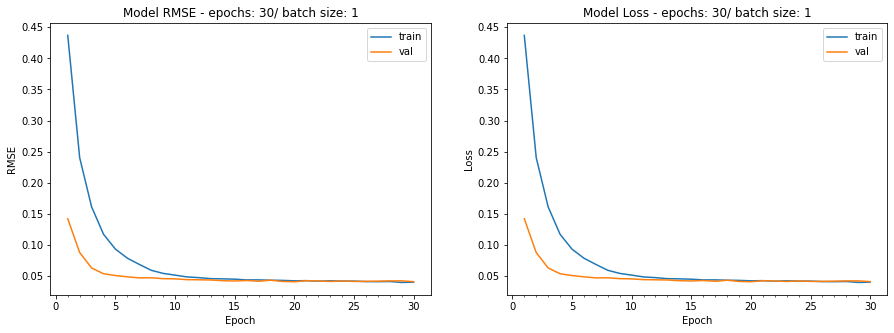

In [24]:
plot_model_history_regressor(history, EPOCHS)

# From Classificator to Regressors

# Final preds

In [26]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def make_predictions(image_path):
    image = image_utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,IMG_SIZE,IMG_SIZE,3)
    image = preprocess_input(image)
    return model.predict(image)

In [37]:
preds = make_predictions('/content/drive/MyDrive/GANsNRoses/datasets/output/pictures/' + '57727f2dedc2cb3880ed5fa9.jpg')

In [38]:
preds

array([[ 0.14275141, -0.05330629]], dtype=float32)

In [39]:
annotations.loc['57727f2dedc2cb3880ed5fa9.jpg']

anger                                                           0
anticipation                                             0.135688
arrogance                                                       0
disgust                                                         0
fear                                                            0
gratitude                                                0.122775
happiness                                                0.183159
humility                                                 0.149958
love                                                            0
optimism                                                 0.149958
pessimism                                                       0
regret                                                          0
sadness                                                         0
shame                                                           0
surprise                                                 0.122775
trust     

In [30]:
annotations.quadrant.head(20)

picture
58c6237dedc2c9c7dc0de1ae.jpg    0
577280dfedc2cb3880f28e76.jpg    2
57727f2dedc2cb3880ed5fa9.jpg    0
58d1240cedc2c94f900fc610.jpg    2
57727de7edc2cb3880e91f26.jpg    2
57728297edc2cb3880f81f5b.jpg    2
5772797dedc2cb3880db5504.jpg    2
57726e48edc2cb3880b69b14.jpg    3
57728255edc2cb3880f7644a.jpg    2
5772843bedc2cb3880fd334d.jpg    2
577285b4edc2cb388001c741.jpg    3
5772898cedc2cb38800df3fd.jpg    3
5772849eedc2cb3880fe72ab.jpg    3
577282b3edc2cb3880f89e19.jpg    3
577284a7edc2cb3880fe813a.jpg    3
57727ca4edc2cb3880e54008.jpg    3
57726ff3edc2cb3880bc56a7.jpg    0
577288deedc2cb38800bdf0f.jpg    2
57726e25edc2cb3880b60a8b.jpg    2
577288ddedc2cb38800bde1d.jpg    2
Name: quadrant, dtype: int64